In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

In [4]:
train_data_dir = '/Users/yerzhantemirali/Desktop/door state/frames/dataset3/train'
test_data_dir = '/Users/yerzhantemirali/Desktop/door state/frames/dataset3/val'

In [5]:
from torch.utils.data import DataLoader, Dataset
class cats_dogs(Dataset):
  def __init__(self, folder):
    cats = glob(folder+'/cats/*.jpg')
    dogs = glob(folder+'/dogs/*.jpg')
    self.fpaths = cats + dogs
    from random import shuffle, seed; seed(10); shuffle(self.fpaths)
    self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] # dog=1 & cat=0
  def __len__(self): return len(self.fpaths)
  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    return torch.tensor(im / 255, dtype=torch.float32).permute(2, 0, 1).to(device), torch.tensor([target], dtype=torch.float32).to(device)

In [12]:
data = cats_dogs(train_data_dir)
im, label = data[500]

tensor([0.], device='mps:0')


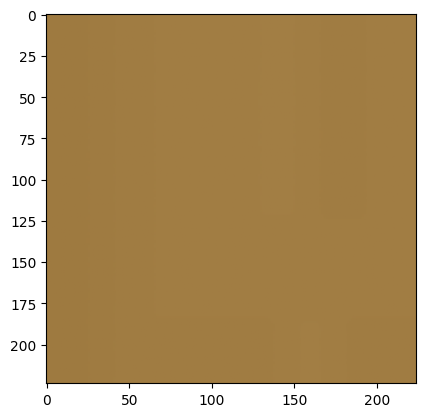

In [13]:

plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [20]:
im.shape

torch.Size([3, 224, 224])

In [ ]:
def conv_layer(ni, no, kernel_size, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, no, kernel_size, stride, padding=kernel_size//2),
        nn.ReLU(),
        nn.BatchNorm2d(no)
    )

def get_model():
    model = nn.Sequential(
        conv_layer(3, 32, 5, stride=1),  # Larger kernel to extract features
        nn.Conv2d(32, 64, 3, stride=2),  # Reduce spatial dim, increase filters
        nn.ReLU(),
        nn.BatchNorm2d(64),

        nn.Flatten(),
        nn.Linear(64 * 14 * 14, 128),  # 14x14 after conv stride
        nn.ReLU(),
        nn.Linear(128, 1),
        nn.Sigmoid()
    ).to(device)

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    return model, loss_fn, optimizer

In [48]:
def conv_layer(ni, no, kernel_size, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, no, kernel_size, stride, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2)  # Downsample feature maps
    )

def get_model():
    model = nn.Sequential(
        conv_layer(3, 32, 3),  # First conv layer (3 → 32)
        conv_layer(32, 64, 3),  # Second conv layer (32 → 64)
        nn.Flatten(),
        nn.Linear(64 * 56 * 56, 1),  # Adjusted input size
        nn.Sigmoid(),
    ).to(device)

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [49]:
from torchsummary import summary

model, loss_fn, optimizer = get_model()

summary(model.to("cpu"), input_size=(3, 224, 224))  # Move model to CPU
model.to("mps")  # Move back to MPS after summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
       BatchNorm2d-3         [-1, 32, 224, 224]              64
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,496
              ReLU-6         [-1, 64, 112, 112]               0
       BatchNorm2d-7         [-1, 64, 112, 112]             128
         MaxPool2d-8           [-1, 64, 56, 56]               0
           Flatten-9               [-1, 200704]               0
           Linear-10                    [-1, 1]         200,705
          Sigmoid-11                    [-1, 1]               0
Total params: 220,289
Trainable params: 220,289
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=200704, out_features=1, bias=True)
  (4): Sigmoid()
)

In [50]:
model.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=200704, out_features=1, bias=True)
  (4): Sigmoid()
)

In [51]:

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    y = y.view_as(prediction)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()  
    opt.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    prediction = model(x)
    predicted_labels = (prediction > 0.5).int()  # Convert to int (0 or 1)
    return (predicted_labels == y.int()).cpu().numpy().tolist()

In [45]:
def get_data():     
    train = cats_dogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = cats_dogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [46]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [52]:

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        #print(ix)
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        #validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    #val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0


/opt/anaconda3/envs/door_state/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/door_state/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1
2
3
4


In [53]:
torch.save(model.state_dict(), "simple_cnn.pth")

In [54]:
model, loss_fn, optimizer = get_model()  # Unpack the tuple properly

# Load model weights
model.load_state_dict(torch.load("simple_cnn.pth", map_location=device))

# Set model to evaluation mode
model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=200704, out_features=1, bias=True)
  (4): Sigmoid()
)

In [69]:
def preprocess_image(image_path):
    im = cv2.imread(image_path)[:,:,::-1]  # Convert BGR to RGB
    im = cv2.resize(im, (224, 224))  # Resize to match model input size
    im = torch.tensor(im / 255, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)  # Normalize, reorder channels, and add batch dimension
    return im

In [70]:
image_path = "/Users/yerzhantemirali/Desktop/door state/frames/dataset3/train/dogs/dog4567.jpg"  # Replace with the actual path
input_tensor = preprocess_image(image_path)

# Perform inference
with torch.no_grad():
    output = model(input_tensor)
    prediction = (output.item() > 0.5)  # Convert probability to class label (True = Dog, False = Cat)

# Display the result
print(f"Predicted Class: {'Dog' if prediction else 'Cat'}")

Predicted Class: Dog


In [75]:
import numpy as np
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
def preprocess_image(image_path):
    im = cv2.imread(image_path)[:,:,::-1]  # Convert BGR to RGB
    im = cv2.resize(im, (224, 224))  # Resize to match model input size
    im = torch.tensor(im / 255, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)  # Normalize, reorder channels, and add batch dimension
    return im
def preprocess_frame(frame):
    # frame = frame[:, :, ::-1]  # Convert BGR to RGB
    if frame.shape[-1] == 3:  # Ensure it's a color image before conversion
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (224, 224))  # Resize to match model input size
    frame = torch.tensor(frame / 255, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)  # Normalize, reorder channels, and add batch dimensio
    return frame

In [76]:
import cv2

video_path = "/Users/yerzhantemirali/Desktop/door state/frames/open_videos/4.mp4"  
cap = cv2.VideoCapture(video_path)



x, y, w, h = 930, 73, 28, 29 


while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # Exit if video ends


    if frame is None or frame.shape[0] == 0 or frame.shape[1] == 0:
        continue  # Skip bad frames
    frame = cv2.GaussianBlur(frame, (3, 3), 0)  # Reduce noise



    # Crop the region of interest (ROI)
    roi = frame[y:y+h, x:x+w]  # Crop the ROI

    processed_frame = preprocess_frame(roi)  # Preprocess the frame

    # Run the model on the preprocessed frame
    with torch.no_grad():
        output = model(processed_frame)
        predicted_class = torch.argmax(output).item()



    # Display result
    label = f"Class: {predicted_class}"
    cv2.putText(frame, label, (x, y + 100), cv2.FONT_HERSHEY_SIMPLEX, 
                0.8, (0, 255, 0), 2, cv2.LINE_AA)

    # Draw the ROI box
    cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Show the video with predictions
    cv2.imshow("Video", frame)
    
    print(predicted_class)
    if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to exit
        break



cv2.waitKey(1)
cap.release()
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


-1